In [1]:
import dimod
import numpy as np
import optuna
from dwave.system import DWaveSampler, EmbeddingComposite

from bpp.qubo import Qubo
from bpp.visu import plot_bins, visu_mat

In [3]:
def solve(trial):
    qubo = Qubo.from_json()

    lambda_EC = trial.suggest_float("lambda_EC", 0.001, 10.0)
    lambda_IC = trial.suggest_float("lambda_IC", 0.001, 10.0)
    # time_limit = trial.suggest_float("time_limit", 1, 1000)

    qubo.lambda_EC = lambda_EC * np.ones(qubo.lambda_EC.shape)
    qubo.lambda_IC = lambda_IC * np.ones(qubo.lambda_IC.shape)

    bqm = dimod.BQM.from_qubo(qubo.Q, offset=qubo.offset)
    sampler = DWaveSampler(region="eu-central-1")
    sampler_qpu = EmbeddingComposite(sampler)
    response = sampler_qpu.sample(bqm, num_reads=10, return_embedding=True)
    return response, qubo

In [4]:
def objective(trial):
    response, _ = solve(trial)

    occurences = response.record["num_occurrences"]
    samples = response.record["sample"]

    qubo = Qubo.from_json()
    energy_sum = 0
    for count, sample in zip(occurences, samples):
        energy_norm = np.matmul(sample, qubo.Q)
        energy_norm = np.matmul(energy_norm, sample)
        if qubo.check_vadility(sample):
            energy_norm -= 100
        energy_sum += energy_norm * count

    return energy_sum / sum(occurences)

In [5]:
study = optuna.create_study()
study.optimize(objective, n_trials=100)

print(study.best_params)

[I 2023-12-28 18:20:39,699] A new study created in memory with name: no-name-319a9694-e007-4d9c-b4d5-ca9c89fbb890
[I 2023-12-28 18:20:44,134] Trial 0 finished with value: 300.6 and parameters: {'lambda_EC': 4.7420438492006, 'lambda_IC': 3.0870642345415535}. Best is trial 0 with value: 300.6.
[I 2023-12-28 18:20:47,457] Trial 1 finished with value: 290.3 and parameters: {'lambda_EC': 1.7858261738012162, 'lambda_IC': 7.189878406052673}. Best is trial 1 with value: 290.3.
[I 2023-12-28 18:20:51,792] Trial 2 finished with value: 223.0 and parameters: {'lambda_EC': 6.603157254936956, 'lambda_IC': 7.115023970890349}. Best is trial 2 with value: 223.0.
[I 2023-12-28 18:20:57,712] Trial 3 finished with value: 244.1 and parameters: {'lambda_EC': 7.718532433168124, 'lambda_IC': 5.845276048526197}. Best is trial 2 with value: 223.0.
[I 2023-12-28 18:21:03,993] Trial 4 finished with value: 185.3 and parameters: {'lambda_EC': 9.935561796431006, 'lambda_IC': 9.788406817692271}. Best is trial 4 with 

{'lambda_EC': 7.105452895980776, 'lambda_IC': 0.5272858197177578}


In [21]:
response, qubo = solve(study.best_trial)

In [22]:
df = response.to_pandas_dataframe()
df.sort_values("energy", inplace=True)
df

,0,1,2,3,4,5,6,7,8,9,...,73,74,75,76,77,78,79,chain_break_fraction,energy,num_occurrences
1,0,0,0,1,0,0,0,0,1,0,...,0,0,1,1,1,0,1,0.0250,214.709500,1
0,0,0,1,0,0,0,0,0,1,0,...,0,0,1,1,1,0,1,0.0250,294.103271,1
2,1,0,0,0,0,0,0,0,0,0,...,0,0,1,1,0,0,0,0.0125,302.545764,1
6,0,1,0,0,1,0,0,0,0,0,...,1,0,1,0,0,0,0,0.0125,308.670367,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0.0250,319.365778,1
5,0,0,0,0,1,0,0,0,1,0,...,0,0,0,0,1,1,0,0.0125,319.952856,1
7,1,1,0,1,0,0,0,0,0,0,...,0,1,1,0,0,0,1,0.0125,324.427011,1
4,1,0,0,0,0,0,0,0,1,0,...,0,1,0,1,0,0,0,0.0125,326.941807,1
8,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0.0125,336.360738,1
9,0,1,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0.0250,437.274414,1


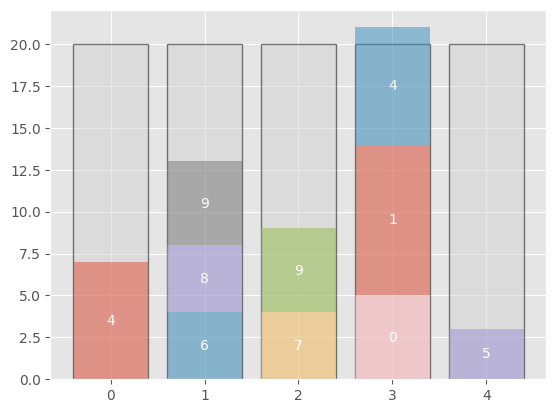

In [23]:
plot_bins(df.iloc[0], qubo)

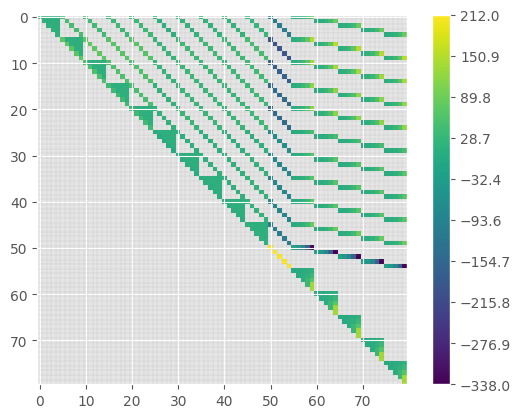

In [24]:
visu_mat(qubo.Q)

/var/folders/s5/_h625fmn4yn76qswyv0f9m8c0000gn/T/ipykernel_16303/1447480103.py:1: ExperimentalWarning: plot_contour is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_contour(
[W 2023-12-28 18:42:12,112] Output figures of this Matplotlib-based `plot_contour` function would be different from those of the Plotly-based `plot_contour`.


<Axes: title={'center': 'Contour Plot'}, xlabel='lambda_EC', ylabel='lambda_IC'>

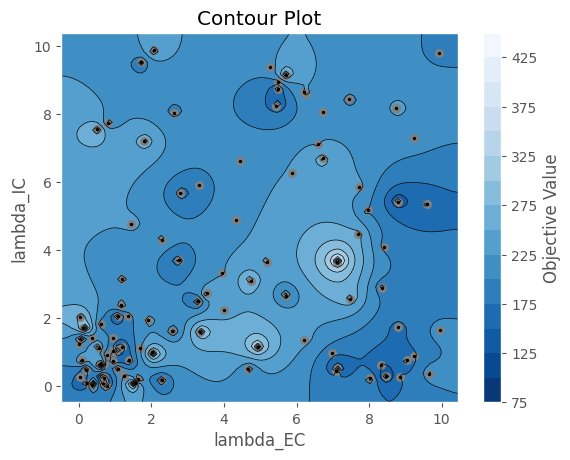

In [25]:
optuna.visualization.matplotlib.plot_contour(
    study, params=["lambda_EC", "lambda_IC"]
)

/var/folders/s5/_h625fmn4yn76qswyv0f9m8c0000gn/T/ipykernel_16303/1455980257.py:1: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study)


<Axes: title={'center': 'Optimization History Plot'}, xlabel='Trial', ylabel='Objective Value'>

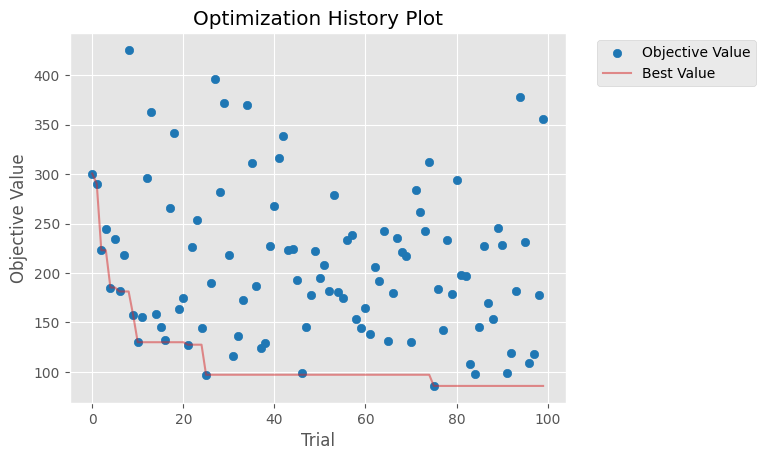

In [26]:
optuna.visualization.matplotlib.plot_optimization_history(study)

/var/folders/s5/_h625fmn4yn76qswyv0f9m8c0000gn/T/ipykernel_16303/1036994904.py:1: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_param_importances(study)


<Axes: title={'left': 'Hyperparameter Importances'}, xlabel='Hyperparameter Importance', ylabel='Hyperparameter'>

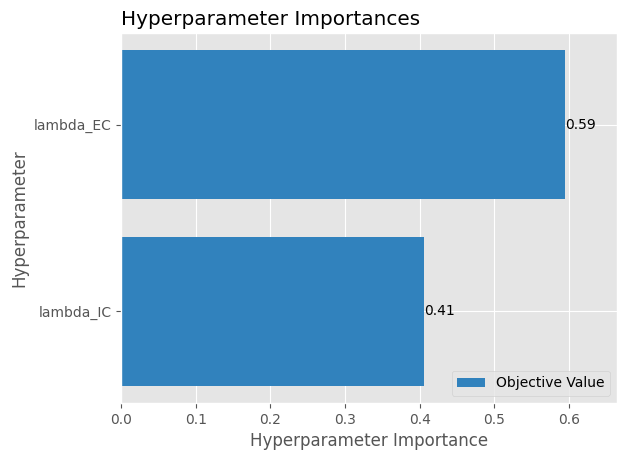

In [27]:
optuna.visualization.matplotlib.plot_param_importances(study)